## 简答题

1. Glorot初始化和He初始化为了解决什么问题
a,梯度消失/爆炸:激活值和梯度在反向传播时可能指数级缩小或放大，导致训练困难。
b,激活值分布控制:不同激活函数通过调整方差保持前向/反向传播的信号强度。
c.对称性问题:避免所有神经元学习相同特征（需随机初始化）。

2. 是否可以将所有权重初始化为相同的值（只要该值是使用He初始化随机选择的）
不能。相同初始化会导致对称性问题：所有神经元在前向传播和反向传播中计算完全相同的梯度，无法学习不同特征

3. 将偏置项初始化为0可以吗
可以。偏置的梯度与权重不同，其更新不依赖前层神经元的激活值，因此初始化为0不会引发对称性问题。

4. 总结下讨论过的激活函数，并讲述在什么情况下使用它们
Sigmoid：二分类输出层（需概率0-1）
Tanh：需零均值输出的隐藏层
ReLU：隐藏层默认选择（计算快、缓解梯度消失），注意死亡神经元（负输入时梯度为0）。
Leaky ReLU：ReLU的改进版，避免死亡神经元，斜率可调。
ELU：需平滑负区间时（如生成模型），计算成本高于ReLU。
Softmax：多分类输出层（概率归一化），必须与交叉熵损失配合使用。

5. 如果在使用SGD优化器时将momentum超参数设置得太接近1（例如0.99999)会发生什么情况
梯度更新惯性极大；
震荡与发散；
训练损失可能突然飙升导致无法收敛。

6. 列举三种能产生稀疏模型得方法
a,正则化
b,剪枝
c.使用稀疏激活函数。

7. dropout会减慢训练速度吗？它会减慢推理（即对新实例进行预测）速度吗？MC dropout呢？
训练速度：会减慢。因每次迭代需随机屏蔽神经元，相当于训练子网络，且需额外计算dropout mask。
推理速度：不会减慢。推理时dropout被关闭，所有神经元参与计算，权重需按保留概率缩放。
MC Dropout：会减慢推理速度。因需多次前向传播（如10次）模拟贝叶斯平均，每次随机屏蔽神经元，推理时间乘以采样次数。

## 编程题

在CIFAR10图像数据集上练习训练深度神经网络：

CIFAR-10数据集，又称加拿大高等研究院数据集（Canadian Institute for Advanced Research）是一个常用于训练机器学习和计算机视觉算法的图像集合。它是最广泛使用的机器学习研究数据集之一。

CIFAR-10数据集包含60,000张32×32像素的彩色图像，分为10个不同的类别。这10个类别分别是飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车，每个类别有6,000张图片。

飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车 对应的分类编码是0，1，2，3，4，5，6，7，8，9


1. 构建一个DNN，使其包含20个隐藏层，每个隐藏层包含100个神经元。使用He初始化和Swish激活函数。
2. 使用Nadam优化和早停技术，在CIFAR10数据集上训练网络。可以使用tf.keras.datasets.cifar10.load_data()加载数据。该数据集由10个类别的60000幅32×32像素的彩色图像（用于训练的50000个，用于测试的10000个）组成，因此需要一个具有10个神经元的softmax输出层。记住，每次更改模型的架构或超参数时，都要找寻正确的学习率。
3. 尝试添加批量归一化并比较学习曲线：收敛速度是否比以前快？会产生更好的模型吗？它如何影响训练速度？
4. 尝试用SELU替换批量归一化，并进行必要的调整以确保网络是自归一化的（即归一化输入特征，使用LeCun正态初始化，确保DNN仅仅包含一系列的密集层等）
5. 尝试使用Alpha dropout正则化模型。然后，在不重新训练模型的情况下，看看是否可以使用MC dropout获得更好的精度。
6. 使用1周期调度来重新训练模型，看看它是否可以提高训练速度和模型精度。

加载数据的代码： tf.keras.datasets.cifar10.load_data()

下载失败的解决方案：
1. 下载文件： cifar-10-python.tar.gz （会把文件发群里）
2. 将文件 cifar-10-python.tar.gz 重命名为 cifar-10-batches-py.tar.gz
3. 并复制到类似 C:\Users\某个用户名或者管理员\.keras\datasets 的路径。将 某个用户名或者管理员 替换为你的用户名。如果是 Linux/Macos 系统，则应为 /home/某个用户名或者管理员/.keras/datasets。

In [12]:
# 加载数据的代码
import tensorflow as tf
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
# 查看数据集形状
print("训练集图片形状:", X_train_full.shape) # 应该是 (50000, 32, 32, 3)
print("训练集标签形状:", y_train_full.shape) # 应该是 (50000, 1)

训练集图片形状: (50000, 32, 32, 3)
训练集标签形状: (50000, 1)


In [13]:
# 按0-9顺序定义类别：飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

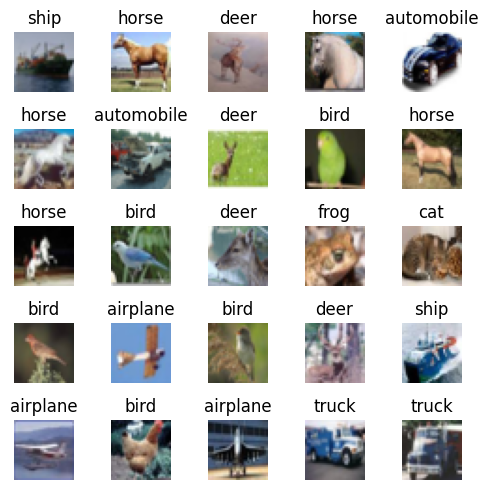

In [14]:
import numpy as np
import matplotlib.pyplot as plt

nrows = 5
ncols = 5

plt.figure(figsize=(5, 5))


random_indices = np.random.choice(len(X_train_full), nrows * ncols, replace=False)  # 无放回随机抽索引

for i, idx in enumerate(random_indices):
    plt.subplot(nrows, ncols, i+1)
    img = X_train_full[idx]
    label = y_train_full[idx, 0]
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

# 调整子图之间的间距，防止标题等重叠
plt.tight_layout()
plt.show()

In [ ]:
# 1. 构建一个DNN，使其包含20个隐藏层，每个隐藏层包含100个神经元。使用He初始化和Swish激活函数。
# 2. 使用Nadam优化和早停技术，在CIFAR10数据集上训练网络。可以使用tf.keras.datasets.cifar10.load_data()加载数据。该数据集由10个类别的60000幅32×32像素的彩色图像（用于训练的50000个，用于测试的10000个）组成，因此需要一个具有10个神经元的softmax输出层。记住，每次更改模型的架构或超参数时，都要找寻正确的学习率。

In [10]:
#加载数据
import tensorflow as tf
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [11]:
print(X_train.dtype)
print(X_train.shape)
print(X_test.dtype)
print(X_test.shape)



uint8
(50000, 32, 32, 3)
uint8
(10000, 32, 32, 3)


In [12]:
X_train.shape[0]

50000

In [13]:
X_train = X_train.astype('float32') / 255.0
X_test  = X_test.astype('float32')  / 255.0
y_train = y_train.squeeze()
y_test  = y_test.squeeze()

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import os


inputs = tf.keras.layers.Input(shape=(32, 32, 3))
x = Flatten()(inputs)

for _ in range(20):

       units = 100
       #He初始化和Swish激活函数。
       x = tf.keras.layers.Dense(units, kernel_initializer='he_normal',activation='swish')(x)

outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


In [6]:
lr =5e-5
opt = tf.keras.optimizers.Nadam(learning_rate=lr)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [7]:
os.makedirs("ckpt", exist_ok=True)
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("ckpt/cifar10_best.weights.h5",
                save_best_only=True,
                save_weights_only=True),
    TensorBoard(log_dir="logs")
]


In [9]:
model.fit(X_train, y_train,
          epochs=150,
          batch_size=128,
          validation_split=0.1,
          callbacks=callbacks,
          verbose=1)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"acc = {test_acc:.4f}")
print(f"loss = {test_loss:.4f}")

Epoch 1/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5690 - loss: 1.2047 - val_accuracy: 0.4934 - val_loss: 1.4599
Epoch 2/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5703 - loss: 1.1973 - val_accuracy: 0.4918 - val_loss: 1.4648
Epoch 3/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5749 - loss: 1.1933 - val_accuracy: 0.4942 - val_loss: 1.4699
Epoch 4/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5751 - loss: 1.1854 - val_accuracy: 0.4916 - val_loss: 1.4867
Epoch 5/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5776 - loss: 1.1813 - val_accuracy: 0.4912 - val_loss: 1.4681
Epoch 6/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5813 - loss: 1.1720 - val_accuracy: 0.4894 - val_loss: 1.4819
Epoch 7/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5823 - loss: 1.1658 - val_accuracy: 0.4930 - val_loss: 1.4691
Epoch 8/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5859 - loss: 1.1585 - val_accu

In [ ]:
# 尝试添加批量归一化并比较学习曲线：收敛速度是否比以前快？会产生更好的模型吗？它如何影响训练速度？

In [110]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [111]:
inputs = tf.keras.layers.Input(shape=(32, 32, 3))
x = Flatten()(inputs)

for _ in range(20):
    units = 100
    x = tf.keras.layers.Dense(units, kernel_initializer='he_normal', activation='swish')(x)
    x = tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

lr = 5e-4
opt = tf.keras.optimizers.Nadam(learning_rate=lr)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

os.makedirs("ckpt", exist_ok=True)
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("ckpt/cifar10_best.weights.h5",
                    save_best_only=True,
                    save_weights_only=True),
    TensorBoard(log_dir="logs")
]


In [112]:
model.fit(X_train, y_train,
          epochs=150,
          batch_size=128,
          validation_split=0.1,
          callbacks=callbacks,
          verbose=1)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"acc = {test_acc:.4f}")
print(f"loss = {test_loss:.4f}")

Epoch 1/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.1500 - loss: 2.3938 - val_accuracy: 0.1898 - val_loss: 2.2883
Epoch 2/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2608 - loss: 2.0093 - val_accuracy: 0.2708 - val_loss: 1.9824
Epoch 3/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3298 - loss: 1.8375 - val_accuracy: 0.3258 - val_loss: 1.8465
Epoch 4/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3742 - loss: 1.7285 - val_accuracy: 0.3606 - val_loss: 1.7920
Epoch 5/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4067 - loss: 1.6546 - val_accuracy: 0.3618 - val_loss: 1.7659
Epoch 6/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4281 - loss: 1.6009 - val_accuracy: 0.3874 - val_loss: 1.7052
Epoch 7/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.4455 - loss: 1.5533 - val_accuracy: 0.4372 - val_loss: 1.6060
Epoch 8/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4628 - loss: 1.5090 -

In [ ]:
# 尝试用SELU替换批量归一化，并进行必要的调整以确保网络是自归一化的（即归一化输入特征，使用LeCun正态初始化，确保DNN仅仅包含一系列的密集层等）

In [19]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype("float32")
X_test  = X_test.astype("float32")
y_train = y_train.squeeze()
y_test  = y_test.squeeze()

mean = X_train.mean(axis=(0,1,2), keepdims=True)
std  = X_train.std (axis=(0,1,2), keepdims=True)
X_train = (X_train - mean) / std
X_test  = (X_test  - mean) / std


In [20]:
inputs = tf.keras.layers.Input(shape=(32, 32, 3))
x = Flatten()(inputs)

for _ in range(20):
    units = 100
    x = tf.keras.layers.Dense(units, kernel_initializer='lecun_normal', activation='selu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

lr = 1e-4
opt = tf.keras.optimizers.Nadam(learning_rate=lr)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [21]:
os.makedirs("ckpt", exist_ok=True)
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("ckpt/cifar10_best.weights.h5",
                    save_best_only=True,
                    save_weights_only=True),
    TensorBoard(log_dir="logs")
]

In [22]:
model.fit(X_train, y_train,
          epochs=150,
          batch_size=128,
          validation_split=0.1,
          callbacks=callbacks,
          verbose=1)

# 6. 评估
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"SELU Test accuracy = {test_acc:.4f}")

Epoch 1/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3458 - loss: 1.8322 - val_accuracy: 0.3830 - val_loss: 1.7242
Epoch 2/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4260 - loss: 1.6128 - val_accuracy: 0.4412 - val_loss: 1.6046
Epoch 3/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4643 - loss: 1.5128 - val_accuracy: 0.4658 - val_loss: 1.5380
Epoch 4/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4912 - loss: 1.4386 - val_accuracy: 0.4658 - val_loss: 1.5142
Epoch 5/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5163 - loss: 1.3728 - val_accuracy: 0.4812 - val_loss: 1.4842
Epoch 6/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5346 - loss: 1.3202 - val_accuracy: 0.4930 - val_loss: 1.4599
Epoch 7/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5496 - loss: 1.2802 - val_accuracy: 0.4932 - val_loss: 1.4447
Epoch 8/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5664 - loss: 1.2322 - val_accu

In [ ]:
# 5. 尝试使用Alpha dropout正则化模型。然后，在不重新训练模型的情况下，看看是否可以使用MC dropout获得更好的精度。

In [92]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype("float32")
X_test  = X_test.astype("float32")
y_train = y_train.squeeze()
y_test  = y_test.squeeze()

mean = X_train.mean(axis=(0,1,2), keepdims=True)
std  = X_train.std (axis=(0,1,2), keepdims=True)
X_train = (X_train - mean) / std
X_test  = (X_test  - mean) / std


In [93]:
from tensorflow.keras.layers import Input, Flatten, Dense, AlphaDropout

inputs = Input(shape=(32, 32, 3))
x = Flatten()(inputs)

for _ in range(20):
    x = Dense(100, kernel_initializer='lecun_normal', activation='selu')(x)
    x = AlphaDropout(rate=0.01)(x)
outputs = Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Nadam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [94]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("ckpt/alpha_drop.weights.h5",
                    save_best_only=True,
                    save_weights_only=True),
    TensorBoard(log_dir="logs")
]

In [95]:
model.fit(X_train, y_train,
          epochs=150,
          batch_size=128,
          validation_split=0.1,
          callbacks=callbacks,
          verbose=1)

Epoch 1/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.2606 - loss: 2.0910 - val_accuracy: 0.3582 - val_loss: 1.8178
Epoch 2/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3423 - loss: 1.8483 - val_accuracy: 0.3988 - val_loss: 1.7249
Epoch 3/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3782 - loss: 1.7473 - val_accuracy: 0.4254 - val_loss: 1.6474
Epoch 4/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4051 - loss: 1.6782 - val_accuracy: 0.4428 - val_loss: 1.6121
Epoch 5/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4269 - loss: 1.6213 - val_accuracy: 0.4548 - val_loss: 1.5783
Epoch 6/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4426 - loss: 1.5793 - val_accuracy: 0.4552 - val_loss: 1.5587
Epoch 7/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4551 - loss: 1.5440 - val_accuracy: 0.4648 - val_loss: 1.5436
Epoch 8/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4672 - loss: 1.5108 - val_accu

In [96]:
import numpy as np

def mc_predict(model, x, T=50):
    preds = np.stack([model(x, training=True) for _ in range(T)], axis=0)
    return preds.mean(axis=0)

In [97]:
y_prob_mc = mc_predict(model, X_test, T=50)
y_pred_mc = y_prob_mc.argmax(-1)
mc_acc = np.mean(y_pred_mc == y_test)

print(f"MC-dropout   accuracy  : {mc_acc:.4f}")

MC-dropout   accuracy  : 0.5155


In [ ]:
#用1周期调度来重新训练模型

In [51]:
# 搜索最佳学习率：即通过以指数方式增加学习率，根据学习率变化绘制训练损失，并找到损失激增的点
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

class LearningRateChange(tf.keras.callbacks.Callback):
    def __init__(self, min_lr, max_lr, batches_per_epoch):
        super().__init__()
        self.min_lr   = min_lr
        self.max_lr   = max_lr
        self.steps    = int(batches_per_epoch)
        self.lr_mult  = (max_lr / min_lr) ** (1 / self.steps)
        self.lrs      = []
        self.losses   = []

    # ---------- 每个 batch 开始前调 ----------
    def on_batch_begin(self, batch, logs=None):
        lr = self.min_lr * (self.lr_mult ** batch)
        self.model.optimizer.learning_rate = lr
        self.lrs.append(lr)

    # ---------- 每个 batch 结束后调 ----------
    def on_batch_end(self, batch, logs=None):
        self.losses.append(logs['loss'])

    # ---------- 训练结束后调 ----------
    def on_train_end(self, logs=None):
        self.plot()

    # ---------- 画图 ----------
    def plot(self, skip=10):
        lrs    = np.array(self.lrs[skip:-skip])
        losses = np.array(self.losses[skip:-skip])

        plt.figure(figsize=(6, 4))
        plt.plot(lrs, losses, color='tab:blue')
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')

        # 最优点
        best_idx = np.argmin(losses)
        best_lr  = lrs[best_idx]
        best_loss = losses[best_idx]

        plt.scatter([best_lr], [best_loss], color='red', zorder=3)

        # 水平辅助线
        plt.axhline(y=best_loss, xmin=0, xmax=best_lr/lrs[-1],
                    color='red', linestyle='--', alpha=0.7)

        # 文字标注
        plt.text(best_lr * 1.5, best_loss,
                 f'best lr = {best_lr:.2e}',
                 color='red', va='center')

        plt.title('Learning rate vs Loss')
        plt.show()

        # 保存最优学习率
        self.best_lr = float(best_lr)


In [52]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        self.model.optimizer.learning_rate = lr

In [76]:
import tensorflow as tf
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype("float32")
X_test  = X_test.astype("float32")
y_train = y_train.squeeze()
y_test  = y_test.squeeze()

mean = X_train.mean(axis=(0,1,2), keepdims=True)
std  = X_train.std (axis=(0,1,2), keepdims=True)
X_train = (X_train - mean) / std
X_test  = (X_test  - mean) / std


In [77]:
from tensorflow.keras.layers import Input, Flatten, Dense, AlphaDropout

inputs = Input(shape=(32, 32, 3))
x = Flatten()(inputs)

for _ in range(20):
    x = Dense(100, kernel_initializer='lecun_normal', activation='selu')(x)
    x = AlphaDropout(rate=0.01)(x)
outputs = Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)



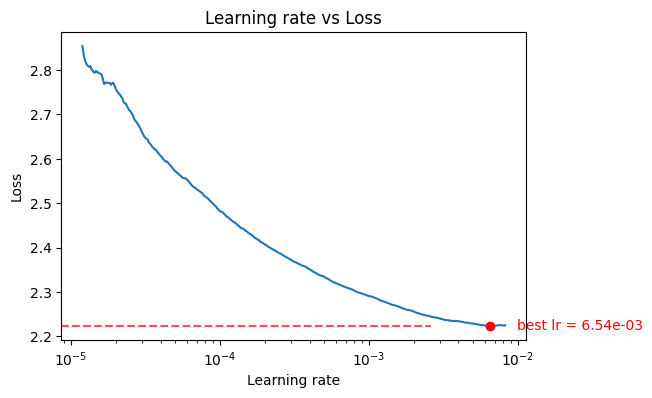

Suggested learning rate:0.0065


In [78]:
batch_size = 128
steps      = np.ceil(X_train.shape[0] / batch_size)
learning_finder = LearningRateChange(min_lr=1e-5, max_lr=0.01, batches_per_epoch=steps)

model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=1,
          verbose=0,
          callbacks=[learning_finder])

# 4. 取出最优学习率
print(f"Suggested learning rate:{learning_finder.best_lr:.4f}")

In [79]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

In [86]:
import math

epochs       = 25
batch_size   = 128
steps_per_epochs = math.ceil(len(X_train) / batch_size)
total_iters  = epochs * steps_per_epochs

best_lr          = 0.001
onecycle = OneCycleScheduler(
        iterations      = total_iters,
        max_lr          = best_lr)

In [87]:
model.fit(X_train, y_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_split=0.1,
          callbacks=[onecycle,early_stop],
          verbose=1)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"after OneCycleScheduler Test accuracy = {test_acc:.4f}")

Epoch 1/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5509 - loss: 1.2683 - val_accuracy: 0.5128 - val_loss: 1.4226
Epoch 2/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5557 - loss: 1.2629 - val_accuracy: 0.5146 - val_loss: 1.4603
Epoch 3/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5532 - loss: 1.2651 - val_accuracy: 0.5112 - val_loss: 1.4298
Epoch 4/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5580 - loss: 1.2548 - val_accuracy: 0.5124 - val_loss: 1.4614
Epoch 5/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5625 - loss: 1.2472 - val_accuracy: 0.5130 - val_loss: 1.4884
Epoch 6/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5622 - loss: 1.2408 - val_accuracy: 0.5110 - val_loss: 1.4534
Epoch 7/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5682 - loss: 1.2324 - val_accuracy: 0.4910 - val_loss: 1.4905
Epoch 8/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5728 - loss: 1.2243 - val_accuracy: 0.